<a href="https://colab.research.google.com/github/dbamman/nlp22/blob/master/HW2/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import sys, argparse
from scipy import sparse
from sklearn import linear_model
from collections import Counter
import numpy as np
import re
from collections import Counter, defaultdict
import operator
import nltk
import csv
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from pandas import option_context

In [1]:
!python -m nltk.downloader punkt

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Let's download the data we'll use for training and development, and also the data we'll use to make predictions for.

In [3]:
# Get data
!wget https://raw.githubusercontent.com/dbamman/nlp22/main/HW2/train.txt
!wget https://raw.githubusercontent.com/dbamman/nlp22/main/HW2/dev.txt
!wget https://raw.githubusercontent.com/dbamman/nlp22/main/HW2/test.txt

--2022-02-03 00:13:35--  https://raw.githubusercontent.com/dbamman/nlp22/main/HW2/train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1322055 (1.3M) [text/plain]
Saving to: ‘train.txt’

train.txt           100%[===================>]   1.26M  --.-KB/s    in 0.07s   

2022-02-03 00:13:35 (19.3 MB/s) - ‘train.txt’ saved [1322055/1322055]

--2022-02-03 00:13:35--  https://raw.githubusercontent.com/dbamman/nlp22/main/HW2/dev.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1309909 (1.2M) [text/plain]
Saving to: ‘dev.txt’

dev.

In [4]:
trainingFile = "train.txt"
evaluationFile = "dev.txt"
testFile = "test.txt"

In [5]:
######################################################################
## Do not edit this block of code.
## This defines the classification class which
## loads the data and sets up the model.
######################################################################

class Classifier:

    def __init__(self, feature_method, L2_regularization_strength=1.0, min_feature_count=1):
        self.feature_vocab = {}
        self.feature_method = feature_method
        self.log_reg = None
        self.L2_regularization_strength=L2_regularization_strength
        self.min_feature_count=min_feature_count

        self.trainX, self.trainY, self.trainOrig = self.process(trainingFile, training=True)
        self.devX, self.devY, self.devOrig = self.process(evaluationFile, training=False)
        self.testX, _, self.testOrig = self.process(testFile, training=False)

    # Read data from file
    def load_data(self, filename):
        data = []
        with open(filename, encoding="utf8") as file:
            for line in file:
                cols = line.split("\t")
                idd = cols[0]
                label = cols[1]
                text = cols[2]

                data.append((idd, label, text))
                
        return data

    # Featurize entire dataset
    def featurize(self, data):
        featurized_data = []
        for idd, label, text in data:
            feats = self.feature_method(text)
            featurized_data.append((label, feats))
        return featurized_data

    # Read dataset and returned featurized representation as sparse matrix + label array
    def process(self, dataFile, training = False):
        original_data = self.load_data(dataFile)
        data = self.featurize(original_data)

        if training:
            fid = 0
            feature_doc_count = Counter()
            for label, feats in data:
                for feat in feats:
                    feature_doc_count[feat]+= 1

            for feat in feature_doc_count:
                if feature_doc_count[feat] >= self.min_feature_count:
                    self.feature_vocab[feat] = fid
                    fid += 1

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        Y = [None]*D
        for idx, (label, feats) in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]
            Y[idx] = label

        return X, Y, original_data

    def load_test(self, dataFile):
        data = self.load_data(dataFile)
        data = self.featurize(data)

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        Y = [None]*D
        for idx, (data_id, feats) in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]
            Y[idx] = data_id

        return X, Y

    # Train model and evaluate on held-out data
    def evaluate(self):
        (D,F) = self.trainX.shape
        self.log_reg = linear_model.LogisticRegression(C = self.L2_regularization_strength, max_iter=1000)
        self.log_reg.fit(self.trainX, self.trainY)
        training_accuracy = self.log_reg.score(self.trainX, self.trainY)
        development_accuracy = self.log_reg.score(self.devX, self.devY)
        print("Method: %s, Features: %s, Train accuracy: %.3f, Dev accuracy: %.3f" % (self.feature_method.__name__, F, training_accuracy, development_accuracy))


    # Predict labels for new data
    def predict(self):
        predX = self.log_reg.predict(self.testX)

        with open("%s_%s" % (self.feature_method.__name__, "predictions.csv"), "w", encoding="utf8") as out:
            writer=csv.writer(out)
            writer.writerow(["Id", "Expected"])
            for idx, data_id in enumerate(self.testX):
                writer.writerow([self.testOrig[idx][0], predX[idx]])
        out.close()


    def printWeights(self, n=10):

        reverse_vocab=[None]*len(self.log_reg.coef_[0])
        for k in self.feature_vocab:
            reverse_vocab[self.feature_vocab[k]]=k

        # binary
        if len(self.log_reg.classes_) == 2:
              weights=self.log_reg.coef_[0]

              cat=self.log_reg.classes_[1]
              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

              cat=self.log_reg.classes_[0]
              for feature, weight in list(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1)))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

        # multiclass
        else:
          for i, cat in enumerate(self.log_reg.classes_):

              weights=self.log_reg.coef_[i]

              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

            

*First*, let's define a classifier based on a really simple dictionary-based feature: if the abstract contains the words "love" or "like", the CONTAINS_POSITIVE_WORD feature will fire, and if it contains either "hate" or "dislike", the CONTAINS_NEGATIVE_WORD will fire.  Note how we use `nltk.word_tokenize` to tokenize the text into its discrete words.

In [6]:
def simple_featurize(text):
    feats = {}
    words = nltk.word_tokenize(text)

    for word in words:
        word=word.lower()
        if word == "love" or word == "like":
            feats["contains_positive_word"] = 1
        if word == "hate" or word == "dislike":
            feats["contains_negative_word"] = 1
            
    return feats


Now let's see how that feature performs on the development data.  Note the `L2_regularization_strength` specifies the strength of the L2 regularizer (values closer to 0 = stronger regularization), and the `min_feature_count` specifies how many data points need to contain a feature for it to be allowable as a feature in the model.  Both are ways to prevent the model from overfitting and achieve higher performance.

In [7]:
simple_classifier = Classifier(simple_featurize, L2_regularization_strength=1.0, min_feature_count=1)
simple_classifier.evaluate()

Method: simple_featurize, Features: 2, Train accuracy: 0.509, Dev accuracy: 0.500


First, is this accuracy score any good?  Let's calculate the accuracy of a majority class predictor to provide some context.  Again, this determines the most represented (majority) class in the training data, and then predicts every test point to be this class.

In [8]:
def majority_class(trainY, devY):
    labelCounts=Counter()
    for label in trainY:
        labelCounts[label]+=1
    majority_class=labelCounts.most_common(1)[0][0]
    
    correct=0.
    for label in devY:
        if label == majority_class:
            correct+=1
            
    print("Majority class: %s\tDev accuracy: %.3f" % (majority_class, correct/len(devY)))
majority_class(simple_classifier.trainY, simple_classifier.devY)

Majority class: pos	Dev accuracy: 0.500


# Your assignment

## Deliverable 1

Your job in this homework is to implement a binary bag-of-words model (i.e., one that assigns a feature value of 1 to each word type that is present in the text); and to brainstorm three additional distinct classes of features, justify why they might help improve the performance *over a bag of words* for this task, implement them in code, and then assess their independent performance on the development data. 

Describe your features and report their performance in the table below; implement the features in the specified `feature1`, `feature2`, and `feature3` functions, and execute each respective classifier to show its performance.  

|Feature|Why should it work? (50 words each)|Best dev set performance|Train set performance|L2|
|---|---|---|---|---|
|Bag of words||0.789|0.982|3e-2
|Absence-inverted AFINN scores|This feature is stronger than just the presence/absence of words like in BOW. If a negative word isn't present, it gets a strong positive weight and vice versa.|0.778|0.965|1e-1
|Bigrams|Bigrams convey more positional information than unigrams used in BOW.|0.755|1.000|1e0
|Sinusoidal position embeddings|Words closer together have a closer value, allowing the model to gain more structural information.|0.770|0.936|1e-2
|Overall||0.823|0.988|6e-3

Note that it is not required for your features to actually perform well, but your justification for why it *should* perform better than a bag of words should be defensible.  The most creative features (defined as features that few other students use and that are reasonably well-performing) will receive extra credit for this assignment.


In [9]:
def bag_of_words(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    return {t: 1 for t in set(nltk.word_tokenize(text.lower()))}


In [10]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################
bow_classifier = Classifier(bag_of_words, L2_regularization_strength=3e-2, min_feature_count=1)
bow_classifier.evaluate()

Method: bag_of_words, Features: 21254, Train accuracy: 0.982, Dev accuracy: 0.789


In [11]:
!wget https://raw.githubusercontent.com/fnielsen/afinn/master/afinn/data/AFINN-en-165.txt
afinn = dict(map(lambda p: (p[0], int(p[1])), [line.split('\t') for line in open("AFINN-en-165.txt")]))
afinn_negative = {f"AFINN_{k}": -v for k, v in afinn.items()}

In [13]:
def feature1(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    
    tokens = set(nltk.word_tokenize(text.lower()))

    feats = afinn_negative.copy()
    for t in tokens:
      t = f"AFINN_{t}"
      if t in afinn_negative:
        feats[t] *= -1

    return feats


In [14]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################
classifier1 = Classifier(feature1, L2_regularization_strength=1e-1, min_feature_count=1)
classifier1.evaluate()

Method: feature1, Features: 3382, Train accuracy: 0.981, Dev accuracy: 0.773


In [15]:
def feature2(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    tokens = nltk.word_tokenize(text)
    bigrams = nltk.bigrams(tokens)
    return {b: 1 for b in bigrams}


In [16]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################
classifier2 = Classifier(feature2, L2_regularization_strength=1e0, min_feature_count=1)
classifier2.evaluate()

Method: feature2, Features: 127808, Train accuracy: 1.000, Dev accuracy: 0.755


In [17]:
def feature3(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    tokens = nltk.word_tokenize(text.lower())
    return {f"POSITION_EMBEDDING_{t}": np.sin((np.pi / 2) + np.pi * (i / 2000)) for i, t in enumerate(tokens)}


In [18]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################
classifier3 = Classifier(feature3, L2_regularization_strength=1e-2, min_feature_count=1)
classifier3.evaluate()

Method: feature3, Features: 21254, Train accuracy: 0.936, Dev accuracy: 0.770


Next, let's combine any or all the features you have developed into one big model and make predictions on the test data.

In [19]:
def combiner_function(text):

    # Here the `all_feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    
  all_feats={}
  for feature in [bag_of_words, feature1, feature2, feature3]:
    all_feats.update(feature(text))
  return all_feats

In [26]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################
big_classifier = Classifier(combiner_function, L2_regularization_strength=6e-3, min_feature_count=1)
big_classifier.evaluate()

#generate .csv file with prediction output on test data
big_classifier.predict()

Method: combiner_function, Features: 173698, Train accuracy: 0.988, Dev accuracy: 0.823


 ## Deliverable 2

This code will generate a file named `combiner_function_predictions.csv`; download this file (using e.g. the file manager on the left panel in Colab) and submit this to GradeScope along with your notebook; the 5 systems with the highest performance (revealed after the submission deadline) will receive extra credit for this assignment.

## Interrogating classifiers

Below you will find several ways in which you can interrogate your model to get ideas on ways to improve its performance.  **Note that nothing below this line requires any work on your part; treat these as useful tools for understanding what works and what doesn't.**

1. First, let's look at the confusion matrix of its predictions (where we can compare the true labels with the predicted labels).  What kinds of mistakes is it making?  (While this is mainly helpful in the context of multiclass classification, we can still see if there's a bias toward predicting a specific class in the binary setting as well). 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


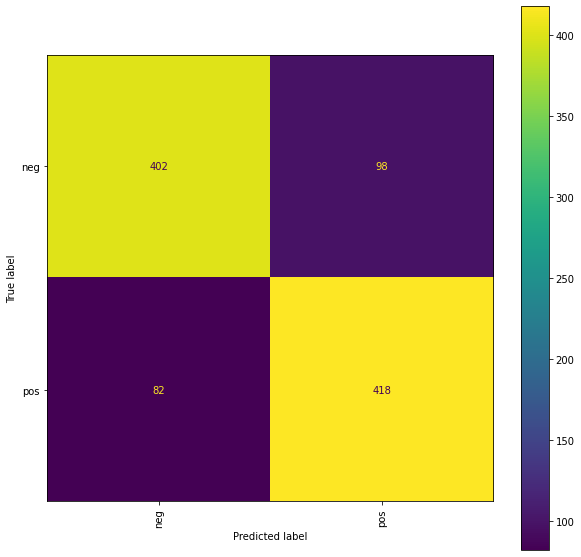

In [22]:
def print_confusion(classifier):
    fig, ax = plt.subplots(figsize=(10,10))
    plot_confusion_matrix(classifier.log_reg, classifier.devX, classifier.devY, ax=ax, xticks_rotation="vertical", values_format="d")
    plt.show()

print_confusion(big_classifier)

2. Next, let's look at the features that are most defining for each of the classes (ranked by how strong their corresponding coefficient is).  Do the features you are defining help in the ways you think they should?  Do sets of successful features suggests others, or complementary features that may provide a different view on the data?

In [23]:
big_classifier.printWeights(n=25)

pos	0.148	AFINN_worst
pos	0.129	AFINN_great
pos	0.115	AFINN_boring
pos	0.109	AFINN_excellent
pos	0.103	AFINN_horrible
pos	0.089	AFINN_stupid
pos	0.088	AFINN_amazing
pos	0.088	AFINN_awful
pos	0.086	AFINN_poor
pos	0.081	AFINN_enjoyed
pos	0.080	AFINN_best
pos	0.078	AFINN_loved
pos	0.077	AFINN_no
pos	0.076	AFINN_poorly
pos	0.076	AFINN_perfect
pos	0.076	AFINN_worse
pos	0.075	AFINN_bad
pos	0.071	AFINN_wonderful
pos	0.070	AFINN_beautifully
pos	0.068	AFINN_top
pos	0.067	('.', 'It')
pos	0.065	AFINN_waste
pos	0.064	AFINN_ridiculous
pos	0.064	AFINN_fails
pos	0.062	AFINN_wonderfully

neg	-0.069	AFINN_violence
neg	-0.058	?
neg	-0.053	POSITION_EMBEDDING_?
neg	-0.050	acting
neg	-0.050	would
neg	-0.049	AFINN_brutal
neg	-0.049	POSITION_EMBEDDING_acting
neg	-0.048	(',', 'I')
neg	-0.048	POSITION_EMBEDDING_would
neg	-0.046	POSITION_EMBEDDING_even
neg	-0.045	AFINN_violent
neg	-0.045	n't
neg	-0.043	POSITION_EMBEDDING_n't
neg	-0.043	could
neg	-0.043	even
neg	-0.042	AFINN_war
neg	-0.041	AFINN_dead
neg	-0.040	

3. Next, let's look at the individual data points that are most mistaken. Does it suggest any features you might create to disentangle them?

In [24]:
def analyze(classifier):
    
    probs=classifier.log_reg.predict_proba(classifier.devX)
    predicts=classifier.log_reg.predict(classifier.devX)

    classes={}
    for idx, lab in enumerate(classifier.log_reg.classes_):
        classes[lab]=idx

    mistakes={}
    for i in range(len(probs)):
        if predicts[i] != classifier.devY[i]:
            predicted_lab_idx=classes[predicts[i]]
            mistakes[i]=probs[i][predicted_lab_idx]

    frame=[]
    sorted_x = sorted(mistakes.items(), key=operator.itemgetter(1), reverse=True)
    for k, v in sorted_x:
        idd=classifier.devOrig[k][0]
        text=classifier.devOrig[k][2]
        frame.append([idd, v, classifier.devY[k], predicts[k], text])

    df=pd.DataFrame(frame, columns=["id", "P(predicted class confidence)", "Human label", "Prediction", "Text"])

    with option_context('display.max_colwidth', 200):
        display(df.head(n=20))


In [25]:
analyze(big_classifier)

,id,P(predicted class confidence),Human label,Prediction,Text
0,1436,0.983385,pos,neg,I have never seen such a movie before. I was on the edge of my seat and constantly laughing throughout the entire movie. I never thought such horrible acting existed it was all just too funny. The...
1,1004,0.947845,neg,pos,"Certainly NOMAD has some of the best horse riding scenes, swordplay, and scrumptious landscape cinematography you'll likely see, but this isn't what makes a film good. It helps but the story has t..."
2,1670,0.905078,neg,pos,"I've always liked Fred MacMurray, andalthough her career was tragically cut shortI think Carole Lombard is fun to watch. Pair these two major and attractive stars together, add top supporting pl..."
3,1456,0.900172,pos,neg,Hardly a masterpiece. Not so well written. Beautiful cinematography i think not. This movie wasn't too terrible but it wasn't that much better than average. The main story dealing with highly immo...
4,1959,0.888030,pos,neg,"This is one of the best episode from the second season of MOH, I think Mick Garris has a problem with women... He kill'em all, they are often the victims (Screwfly solution, Pro-life, Valerie on t..."
5,1822,0.884434,pos,neg,"Zombi 3 has an interesting history in it's making. Firstly, it is a sequel to Fulci's hit Zombi 2, with Zombi 2 itself being of course a marketing ploy to trick people into thinking it was a seque..."
6,1608,0.865752,neg,pos,"As good an advert for republicanism as you're ever likely to see,""Mayerling""is an everyday story of royal folk in late nineteenth century Austria.Set during one of Europe's seemingly incessant int..."
7,1261,0.842752,neg,pos,"NATURAL BORN KILLERS (1994)Cinema Cut: R Director's Cut: NC-17It's an unusual Oliver Stone picture, but when I read he was on drugs during the filming, I needed no further explanation. 'Natural Bo..."
8,1825,0.826533,pos,neg,"Whilst reading through the comments left for this show, I couldn't help but notice that a large percentage of the reviewers had either not actually watched any episodes of the show either all the ..."
9,1659,0.826348,pos,neg,Child 'Sexploitation' is one of the most serious issues facing our world today and I feared that any film on the topic would jump straight to scenes of an explicitly sexual nature in order to shoc...
